# Cats and Dogs classifier

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

In [ ]:
data_dir = "/content/CatsDogs"
categories = ["Cats", "Dogs"]

## Selecting a single file for conversion

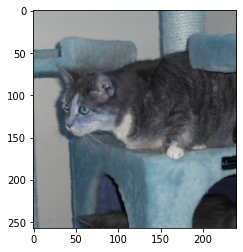

In [ ]:
for category in categories:  # do dogs and cats
    path = os.path.join(data_dir,category)  # create path to dogs and cats
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img))  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

In [ ]:
img_array

array([[[171, 175, 170],
        [170, 174, 169],
        [172, 175, 173],
        ...,
        [140, 142, 142],
        [139, 145, 144],
        [141, 146, 147]],

       [[172, 175, 173],
        [171, 174, 172],
        [173, 175, 175],
        ...,
        [141, 144, 142],
        [140, 145, 144],
        [141, 146, 145]],

       [[171, 173, 173],
        [172, 174, 174],
        [173, 175, 175],
        ...,
        [140, 145, 144],
        [141, 147, 146],
        [140, 146, 145]],

       ...,

       [[109, 130, 145],
        [102, 124, 136],
        [ 99, 121, 127],
        ...,
        [ 67,  66,  70],
        [ 66,  65,  67],
        [ 65,  64,  66]],

       [[103, 120, 133],
        [ 99, 117, 128],
        [108, 129, 137],
        ...,
        [ 57,  57,  63],
        [ 56,  54,  60],
        [ 57,  55,  61]],

       [[106, 125, 138],
        [105, 124, 137],
        [110, 132, 144],
        ...,
        [ 60,  58,  64],
        [ 58,  59,  63],
        [ 59,  61,  62]]

In [ ]:
from PIL import Image
im = Image.fromarray(img_array)
im.save("your_file.jpeg")

In [ ]:
img_array.shape

The size of the image is still big, so we need to transform it into a smaller file

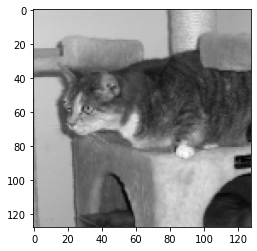

In [ ]:
image_size = 128
new_array = cv2.resize(img_array, (image_size, image_size))
new_array = cv2.cvtColor(new_array, cv2.COLOR_BGR2GRAY)
plt.imshow(new_array, cmap='gray')
plt.show()

In [ ]:
from PIL import Image
im = Image.fromarray(new_array)
im.save("image.jpeg")

In [ ]:
new_array.shape

## Building the training data

In [ ]:
training_data = []
!rm -rf train
!mkdir train
!rm -rf test
!mkdir test
def create_training_data():
    for category in categories:  # do dogs and cats

        path = os.path.join(data_dir,category)  # create path to dogs and cats
        class_num = (category).lower()  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (image_size, image_size))  # resize to normalize data size
                training_data.append([class_num  + img, class_num])  # add this to our training_data
                im = Image.fromarray(new_array)
                im.save("train/"+ class_num  + img)
            except Exception as e:  # in the interest in keeping the output clean...
                pass

create_training_data()

print(len(training_data) / 5)

100%|██████████| 12501/12501 [00:21<00:00, 571.68it/s]

4989.2


In [ ]:
import os
import random
import shutil

source = "train/"
dest = 'test/'
no_of_files = len(files) // 5

for file_name in random.sample(files, no_of_files):
    shutil.move(source + file_name, dest + file_name)

## Randomization

For now, our training data is first cats, and then dogs.
So the reasonable thing to do is randomizing the training data.

In [ ]:
import random

random.shuffle(training_data)

Checking if the data is randomized

In [ ]:
for sample in training_data[:10]:
    print(sample)

['cat5197.jpg', 'cat']
['dog3001.jpg', 'dog']
['dog11411.jpg', 'dog']
['cat3619.jpg', 'cat']
['cat2374.jpg', 'cat']
['dog2020.jpg', 'dog']
['dog4174.jpg', 'dog']
['cat1694.jpg', 'cat']
['dog1507.jpg', 'dog']
['cat8788.jpg', 'cat']


In [ ]:
train_X = [img_fname for img_fname in os.listdir("train/")]
train_X = np.array(train_X)
train_labels = [l.split('/')[-1].split('.')[0].strip('0123456789') for l in train_X]
train_labels = np.array(train_labels)
# 
print ('Training shape:', train_X.shape, train_labels.shape) 
# 
print(train_X[:5], train_labels[:5])

Training shape: (24946,) (24946,)
['dog221.jpg' 'dog5806.jpg' 'cat775.jpg' 'cat30.jpg' 'dog8006.jpg'] ['dog' 'dog' 'cat' 'cat' 'dog']


In [ ]:
train_X

array(['dog221.jpg', 'dog5806.jpg', 'cat775.jpg', ..., 'dog7910.jpg',
       'dog6504.jpg', 'dog1580.jpg'], dtype='<U12')

In [ ]:
test_X = [img_fname for img_fname in os.listdir("test/")]
test_X = np.array(test_X)
test_labels = [l.split('/')[-1].split('.')[0].strip('0123456789') for l in test_X]
test_labels = np.array(test_labels)
# 
print ('testing shape:', test_X.shape, test_labels.shape) 
# 
print(test_X[:5], test_labels[:5])

testing shape: (4989,) (4989,)
['cat5476.jpg' 'cat5447.jpg' 'cat5803.jpg' 'dog1592.jpg' 'dog6774.jpg'] ['cat' 'cat' 'cat' 'dog' 'dog']


# Training models using 5-fold cross validation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import sklearn.model_selection as sklrn
import pandas as pd

def train_and_cross_validate (model, x_data, y_data, epochs=5, batch_size=128):
    # 
    scores = []
    
    #  Loading images through generators ...
    train_datagen = ImageDataGenerator(rescale=1. / 255.,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True)    
    validation_datagen = ImageDataGenerator(rescale=1. / 255)
          
    # prepare cross validation
    kfold = sklrn.KFold(5, shuffle=True, random_state=1)
    # enumerate splits
    FoldsSetNo = 0 
    for train_ix, test_ix in kfold.split(x_data):
        print ('Folds Set # {0}'.format(FoldsSetNo))
        # select rows for train and test
        xx_train, yy_train, xx_test, yy_test = \
            x_data[train_ix], y_data[train_ix], x_data[test_ix], y_data[test_ix]

        # flow training images in batches for the current folds set
        # for training         
        print(xx_train, yy_train)
        train_generator = train_datagen.flow_from_dataframe(
            dataframe = pd.DataFrame({'id':xx_train,'label':yy_train}), 
            directory="train/", 
            x_col='id',
            y_col='label',
            color_mode="grayscale",
            batch_size=batch_size,
            target_size=(128,128),
            class_mode='binary',
            shuffle = False)
        
        # and for validation         
        validation_generator = validation_datagen.flow_from_dataframe(
            dataframe = pd.DataFrame({'id':xx_test,'label':yy_test}), 
            directory="train/", 
            x_col='id',
            y_col='label',
            batch_size=batch_size,
            color_mode="grayscale",
            target_size=(128,128),
            class_mode='binary',
            shuffle=False)

        # fit the model
        history = model.fit(train_generator,
                            epochs=epochs,  # The more we train the more our model fits the data
                            batch_size=batch_size,  # Smaller batch sizes = samller steps towards convergence
                            validation_data=validation_generator,
                            verbose=1)
        # store scores
        scores.append({'acc':np.average(history.history['accuracy']),'val_acc':np.average(history.history['val_accuracy'])})
        x,y=train_generator.next()
        y_lenetpred=model.predict(x)



        loss=[]
        for i, idx in enumerate(np.random.choice(len(validation_generator), size=16, replace=False)):
            pred_idx = np.argmax(y_lenetpred[i])
            true_idx = np.argmax(y[i])

            if pred_idx==true_idx:
                loss.append(0)
            else:
                loss.append(1)


        print("Zero one loss ",np.mean(loss))
        FoldsSetNo +=1
    return scores

# CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
print('Constructing and compiling model ...')
cnnModel = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape=(128,128,1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
cnnModel.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
print('Done')


Constructing and compiling model ...
Done


In [ ]:
cnnModel.summary()

In [ ]:
scores = train_and_cross_validate(cnnModel, train_X, train_labels, 1)

Folds Set # 0
['dog5806.jpg' 'cat30.jpg' 'cat5476.jpg' ... 'dog7910.jpg' 'dog6504.jpg'
 'dog1580.jpg'] ['dog' 'cat' 'cat' ... 'dog' 'dog' 'dog']
Found 19956 validated image filenames belonging to 2 classes.
Found 4990 validated image filenames belonging to 2 classes.
156/156 [==============================] - 33s 211ms/step - loss: 0.4983 - accuracy: 0.7512 - val_loss: 0.4698 - val_accuracy: 0.7723
Zero one loss  0.0
Folds Set # 1
['dog221.jpg' 'dog5806.jpg' 'cat775.jpg' ... 'dog7910.jpg' 'dog6504.jpg'
 'dog1580.jpg'] ['dog' 'dog' 'cat' ... 'dog' 'dog' 'dog']
Found 19957 validated image filenames belonging to 2 classes.
Found 4989 validated image filenames belonging to 2 classes.
156/156 [==============================] - 32s 206ms/step - loss: 0.5046 - accuracy: 0.7522 - val_loss: 0.4164 - val_accuracy: 0.8100
Zero one loss  0.0
Folds Set # 2
['dog221.jpg' 'dog5806.jpg' 'cat775.jpg' ... 'dog4601.jpg' 'dog6504.jpg'
 'dog1580.jpg'] ['dog' 'dog' 'cat' ... 'dog' 'dog' 'dog']
Found 19957 v

[0.751152515411377, 0.7521671652793884, 0.7564263343811035, 0.7596331834793091, 0.7639424800872803]
[0.77229905128479, 0.8099819421768188, 0.8157947659492493, 0.8025656342506409, 0.8226097226142883]


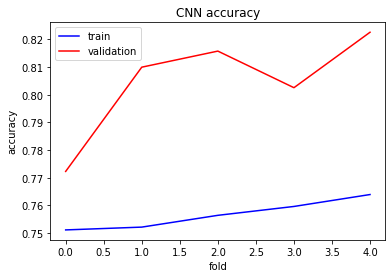

In [ ]:
from matplotlib import pyplot as plt
# summarize history for accuracy
# print(scores)
train = []
validation = []
plt.subplot(1, 1, 1)
for s in scores:
    train.append(s['acc'])
    validation.append(s['val_acc'])
print(train)
print(validation)
plt.plot(train, color='blue', label='train')
plt.plot(validation , color='red', label='validation')
plt.title('CNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('fold')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# VGG3

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
vgg3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape = (128,128,1)),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'softmax')
])

vgg3.compile(optimizer = "adam", loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
vgg3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 conv2d_65 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_66 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_67 (Conv2D)          (None, 64, 64, 64)        36928     
                                                     

In [ ]:
scores = train_and_cross_validate(vgg3, train_X, train_labels, 5)

Folds Set # 0
['dog5806.jpg' 'cat30.jpg' 'cat5476.jpg' ... 'dog7910.jpg' 'dog6504.jpg'
 'dog1580.jpg'] ['dog' 'cat' 'cat' ... 'dog' 'dog' 'dog']
Found 19956 validated image filenames belonging to 2 classes.
Found 4990 validated image filenames belonging to 2 classes.
Epoch 1/5
50/50 [==============================] - 14s 274ms/step - loss: 0.6932 - accuracy: 0.4919 - val_loss: 0.6932 - val_accuracy: 0.5026
Epoch 2/5
50/50 [==============================] - 14s 274ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6931 - val_accuracy: 0.5026
Epoch 3/5
50/50 [==============================] - 13s 260ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6932 - val_accuracy: 0.5026
Epoch 4/5
50/50 [==============================] - 13s 262ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6931 - val_accuracy: 0.5026
Epoch 5/5
50/50 [==============================] - 13s 261ms/step - loss: 0.6932 - accuracy: 0.5066 - val_loss: 0.6931 - val_accuracy: 0.5026
Zero one loss  0.0
Fol

[0.5010916888713837, 0.5004835963249207, 0.501077938079834, 0.4985784888267517, 0.500875049829483]
[0.5026051998138428, 0.49969932436943054, 0.49549007415771484, 0.49929845333099365, 0.5023050904273987]


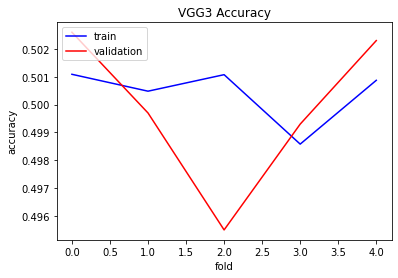

In [ ]:
from matplotlib import pyplot as plt
# summarize history for accuracy
# print(scores)
train = []
validation = []
plt.subplot(1, 1, 1)
for s in scores:
    train.append(s['acc'])
    validation.append(s['val_acc'])
print(train)
print(validation)
plt.plot(train, color='blue', label='train')
plt.plot(validation , color='red', label='validation')
plt.title('VGG3 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('fold')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# VGG13

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
print('Constructing and compiling model ...')
vgg13 = tf.keras.models.Sequential([    
    tf.keras.layers.Conv2D(64,(3,3),activation = 'relu', input_shape = (128,128,1)),
    tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128,(3,3),activation = 'relu'),
    tf.keras.layers.Conv2D(128,(3,3),activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256,(3,3),activation = 'relu'),
    tf.keras.layers.Conv2D(256,(3,3),activation = 'relu'),
    tf.keras.layers.Conv2D(256,(3,3),activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512,(3,3),activation = 'relu'),
    tf.keras.layers.Conv2D(512,(3,3),activation = 'relu'),
    tf.keras.layers.Conv2D(512,(3,3),activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6000,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation = 'softmax')
])
vgg13.compile(optimizer=SGD(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
print('Done')


Constructing and compiling model ...
Done


In [ ]:
vgg13.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 126, 126, 64)      640       
                                                                 
 conv2d_71 (Conv2D)          (None, 124, 124, 64)      36928     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 conv2d_73 (Conv2D)          (None, 58, 58, 128)       147584    
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 29, 29, 128)      0         
 g2D)                                                

In [ ]:
scores = train_and_cross_validate(vgg13, train_X, train_labels,1)

Folds Set # 0
['dog5806.jpg' 'cat30.jpg' 'cat5476.jpg' ... 'dog7910.jpg' 'dog6504.jpg'
 'dog1580.jpg'] ['dog' 'cat' 'cat' ... 'dog' 'dog' 'dog']
Found 19956 validated image filenames belonging to 2 classes.
Found 4990 validated image filenames belonging to 2 classes.
156/156 [==============================] - 43s 277ms/step - loss: 0.6931 - accuracy: 0.4992 - val_loss: 0.6931 - val_accuracy: 0.5026
Zero one loss  0.0
Folds Set # 1
['dog221.jpg' 'dog5806.jpg' 'cat775.jpg' ... 'dog7910.jpg' 'dog6504.jpg'
 'dog1580.jpg'] ['dog' 'dog' 'cat' ... 'dog' 'dog' 'dog']
Found 19957 validated image filenames belonging to 2 classes.
Found 4989 validated image filenames belonging to 2 classes.
156/156 [==============================] - 47s 299ms/step - loss: 0.6931 - accuracy: 0.4999 - val_loss: 0.6931 - val_accuracy: 0.4997
Zero one loss  0.0
Folds Set # 2
['dog221.jpg' 'dog5806.jpg' 'cat775.jpg' ... 'dog4601.jpg' 'dog6504.jpg'
 'dog1580.jpg'] ['dog' 'dog' 'cat' ... 'dog' 'dog' 'dog']
Found 19957 v

[0.49919822812080383, 0.49992483854293823, 0.500977098941803, 0.5000250339508057, 0.4992734491825104]
[0.5026051998138428, 0.49969932436943054, 0.49549007415771484, 0.49929845333099365, 0.5023050904273987]


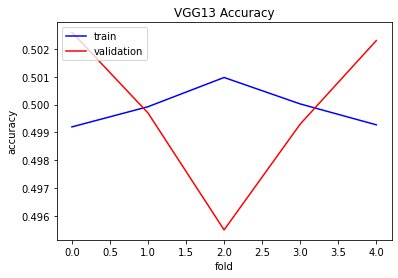

In [ ]:
from matplotlib import pyplot as plt
# summarize history for accuracy
# print(scores)
train = []
validation = []
plt.subplot(1, 1, 1)
for s in scores:
    train.append(s['acc'])
    validation.append(s['val_acc'])
print(train)
print(validation)
plt.plot(train, color='blue', label='train')
plt.plot(validation , color='red', label='validation')
plt.title('VGG13 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('fold')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# LeNet

In [ ]:
lenet = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(128,128,1), padding="same"),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    tf.keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation = 'tanh'),
    tf.keras.layers.Dense(84, activation = 'tanh'),
    tf.keras.layers.Dense(1, activation = 'softmax')
])

lenet.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [ ]:
lenet.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_80 (Conv2D)          (None, 128, 128, 6)       156       
                                                                 
 average_pooling2d_2 (Averag  (None, 64, 64, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_81 (Conv2D)          (None, 60, 60, 16)        2416      
                                                                 
 average_pooling2d_3 (Averag  (None, 30, 30, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_13 (Flatten)        (None, 14400)             0         
                                                                 
 dense_27 (Dense)            (None, 120)             

In [ ]:
scores = train_and_cross_validate(lenet, train_X, train_labels, 1)

Folds Set # 0
['dog5806.jpg' 'cat30.jpg' 'cat5476.jpg' ... 'dog7910.jpg' 'dog6504.jpg'
 'dog1580.jpg'] ['dog' 'cat' 'cat' ... 'dog' 'dog' 'dog']
Found 19956 validated image filenames belonging to 2 classes.
Found 4990 validated image filenames belonging to 2 classes.
50/50 [==============================] - 12s 236ms/step - loss: 0.0000e+00 - accuracy: 0.5047 - val_loss: 0.0000e+00 - val_accuracy: 0.5026
Zero one loss  0.0
Folds Set # 1
['dog221.jpg' 'dog5806.jpg' 'cat775.jpg' ... 'dog7910.jpg' 'dog6504.jpg'
 'dog1580.jpg'] ['dog' 'dog' 'cat' ... 'dog' 'dog' 'dog']
Found 19957 validated image filenames belonging to 2 classes.
Found 4989 validated image filenames belonging to 2 classes.
50/50 [==============================] - 12s 235ms/step - loss: 0.0000e+00 - accuracy: 0.5138 - val_loss: 0.0000e+00 - val_accuracy: 0.4997
Zero one loss  0.0
Folds Set # 2
['dog221.jpg' 'dog5806.jpg' 'cat775.jpg' ... 'dog4601.jpg' 'dog6504.jpg'
 'dog1580.jpg'] ['dog' 'dog' 'cat' ... 'dog' 'dog' 'dog']
F

[0.504687488079071, 0.5137500166893005, 0.5046173334121704, 0.49687498807907104, 0.49828124046325684]
[0.5026051998138428, 0.49969932436943054, 0.49549007415771484, 0.49929845333099365, 0.5023050904273987]


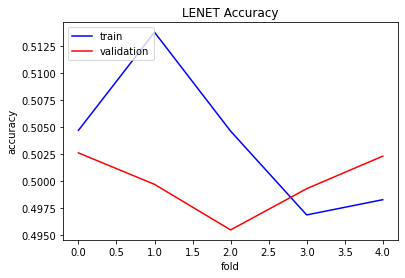

In [ ]:
from matplotlib import pyplot as plt
# summarize history for accuracy
# print(scores)
train = []
validation = []
plt.subplot(1, 1, 1)
for s in scores:
    train.append(s['acc'])
    validation.append(s['val_acc'])
print(train)
print(validation)
plt.plot(train, color='blue', label='train')
plt.plot(validation , color='red', label='validation')
plt.title('LENET Accuracy')
plt.ylabel('accuracy')
plt.xlabel('fold')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()